In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from keras import models
import numpy as np

Load the pretrained MobileNetV2 model and the ImageNet class names

In [2]:
pretrained_model = models.load_model("models/MobileNet-FineTuned-CIFAR10.h5")
pretrained_model.trainable = False

In [3]:
# Preprocess the input image for your fine-tuned model
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (32, 32))  
    image = image / 255.0  
    image = image[None, ...]  
    return image

# Extract label from probability vector
def get_cifar10_label(probs):
    return np.argmax(probs)

In [19]:
from keras import datasets

(_,_),(X_test,y_test) = datasets.cifar10.load_data()

In [30]:
idx = np.random.randint(1,len(X_test))
image = preprocess(X_test[idx])
image_probs = pretrained_model.predict(image)
label = get_cifar10_label(image_probs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


In [32]:
image.shape

TensorShape([1, 32, 32, 3])

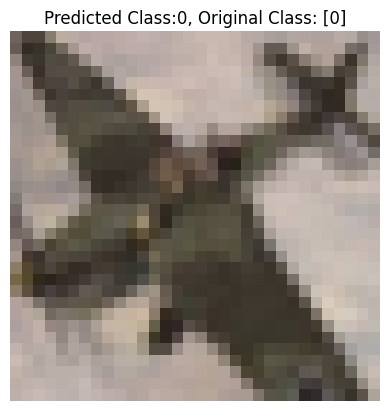

In [31]:
plt.imshow(image[0])
plt.axis('off')
plt.title(f"Predicted Class:{get_cifar10_label(image_probs)}, Original Class: {y_test[idx]}")
plt.show()

## Creating Adversarial Image

### Fast Gradient Sign Method (FGSM)

The first step is to create perturbations which will be used to distort the original image resulting in an adversarial image. For this, the gradients are taken with respect to the image. And trainabed weights are not used.

In [33]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)
    prediction = pretrained_model(input_image)
    loss = loss_object(input_label, prediction)

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)
  return signed_grad

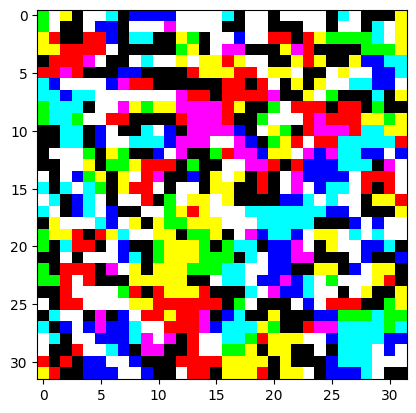

In [40]:
test_image_label = y_test[idx]
label = tf.one_hot(test_image_label, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  

In [41]:
def plot_image(image, description, model):
    preds = model.predict(image)
    label = np.argmax(preds)
    confidence = preds[0][label]
    
    plt.figure()
    plt.imshow(image[0])
    plt.title('{} \n Label: {} with {:.2f}% Confidence'.format(description, label, confidence * 100))
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


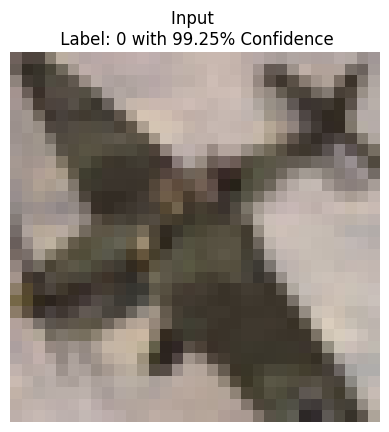

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


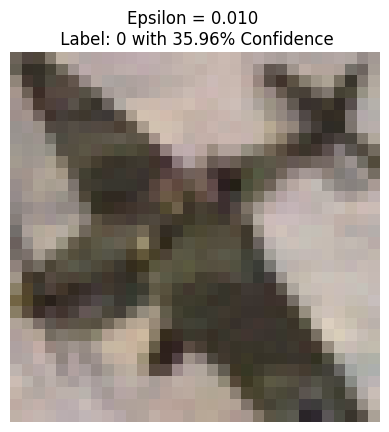

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


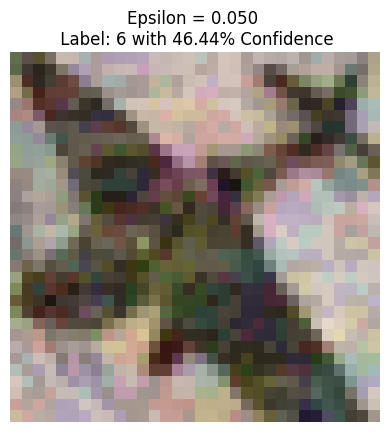

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


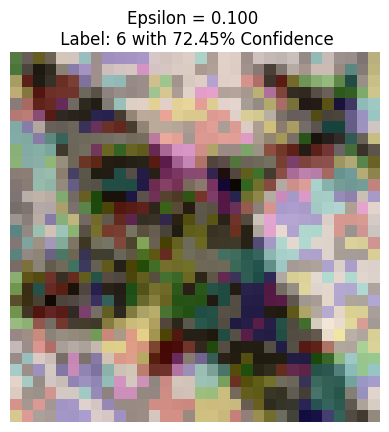

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


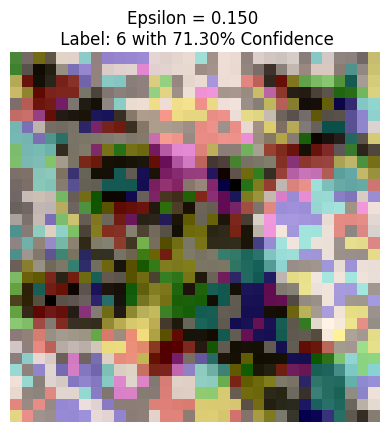

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


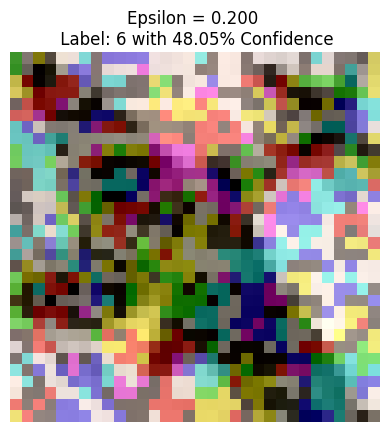

In [43]:
epsilons = [0, 0.01, 0.05, 0.1, 0.15, 0.2]

descriptions = [('Epsilon = {:.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image + eps * perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1)  # Assuming images are in [0, 1] range
    plot_image(adv_x, descriptions[i], pretrained_model)

As expected, as the value of epsilon is increased, it becomes easier to fool the network. However, this comes as a trade-off which results in the perturbations becoming more identifiable.